# Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3. Обработка текстов.

### О задании

В данном домашнем задании вам предстоит предсказывать пользовательскую оценку отеля по тексту отзыва. Нужно обучиться на данных с кэггла и заслать в [соревнование](https://www.kaggle.com/t/3e8fa6cec6d048bf8e93fb72e441d88c) предикт. По той же ссылке можете скачать данные.

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву.

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 0.92 на публичном лидерборде. В противном случае мы будем вынуждены не засчитать задание :( 

#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Для локального тестирования используйте предоставленное разбиение на трейн и тест.

Good luck & have fun! 💪

#### Использовать любые данные для обучения кроме предоставленных организаторами строго запрещено. В последней части можно использовать предобученные модели из библиотеки `transformers`.

In [1]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c intro-to-dl-hw03
!unzip test.csv.zip && unzip train.csv.zip

 57% 5.00M/8.78M [00:00<00:00, 13.6MB/s]
100% 8.78M/8.78M [00:00<00:00, 17.4MB/s]
  0% 0.00/723k [00:00<?, ?B/s]
100% 723k/723k [00:00<00:00, 35.1MB/s]
  0% 0.00/1.75M [00:00<?, ?B/s]
100% 1.75M/1.75M [00:00<00:00, 44.8MB/s]
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


In [2]:
PATH_TO_TRAIN_DATA = 'train.csv'
PATH_TO_TEST_DATA = 'test.csv'

In [3]:
import pandas as pd

df = pd.read_csv(PATH_TO_TRAIN_DATA)
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


In [4]:
df.shape

(100000, 4)

In [ ]:
# df[df['review_id'] == '7133826251118ac1d7926a9201ba2575']['negative'].iloc[0]

Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Идеи для препроцессинга:
* Добавление меток начала/конца предложения/отзыва
* BPE
* Отличаем токены позитива и негатива
* Лемматизация

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [5]:
import string

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

def process_lower(text):
    return text.strip().lower()

def process_tokenize(text):
    return [word for word in word_tokenize(text) if word not in string.punctuation]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
df['negative'] = df['negative'].apply(process_lower)
df['positive'] = df['positive'].apply(process_lower)

Судя по статистике с Kaggle, в негативных отзывах есть две довольно частые категории: `'No Negative'` ($25\%$) и `' Nothing'` ($3\%$). Они означают одно и то же, поэтому имеет смысл объединить их в одну.

In [8]:
def process_rare_negative(text):
    return 'no negative' if (text == 'nothing') or (text == 'no') else text

df['negative'] = df['negative'].apply(process_rare_negative)

In [9]:
df['negative'] = df['negative'].apply(process_tokenize)
df['positive'] = df['positive'].apply(process_tokenize)

In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state=1412) # <- для локального тестирования

### Часть 1. 1 балл

Обучите логистическую или линейную регрессию на TF-IDF векторах текстов.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

def identity_tokenizer(text):
    return text

def get_tfidf_features(df_train, df_test):
    tfidf_neg = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)
    tfidf_pos = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)
    X_train = hstack([tfidf_neg.fit_transform(df_train['negative']),
                    tfidf_pos.fit_transform(df_train['positive'])])
    X_test = hstack([tfidf_neg.transform(df_test['negative']),
                    tfidf_pos.transform(df_test['positive'])])
    return X_train, X_test

In [ ]:
# tfidf_neg.fit(df['negative'])
# tfidf_pos.fit(df['positive'])

In [12]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = *get_tfidf_features(df_train, df_test), df_train['score'], df_test['score']
model = Ridge()
model.fit(X_train, y_train)

print(f'Train MAE: {mean_absolute_error(y_train, model.predict(X_train))}')
print(f'Val MAE: {mean_absolute_error(y_test, model.predict(X_test))}')

Train MAE: 0.7017711052453421
Val MAE: 0.8317001931191635


In [13]:
from sklearn.linear_model import SGDRegressor

mae_model = SGDRegressor(loss='epsilon_insensitive', epsilon=0)
mae_model.fit(X_train, y_train)

print(f'Train MAE: {mean_absolute_error(y_train, mae_model.predict(X_train))}')
print(f'Val MAE: {mean_absolute_error(y_test, mae_model.predict(X_test))}')

Train MAE: 0.9820603420499885
Val MAE: 1.012505571474943


Источники:
* https://stackoverflow.com/questions/48671270/use-sklearn-tfidfvectorizer-with-already-tokenized-inputs

Занимательно, что:
* Если фитить `TfidfVectorizer` на всех данных (включая тестовые), то качество примерно то же;
* Если обучать `SGDRegressor` на MAE, то качетво хуже.

Предскажите этой моделью тестовые данные из [соревнования](https://www.kaggle.com/t/3e8fa6cec6d048bf8e93fb72e441d88c) и сделайте сабмит. Какой у вас получился скор? Прикрепите скриншот из кэггла.

In [14]:
test_data = pd.read_csv(PATH_TO_TEST_DATA)
test_data.head()

,review_id,negative,positive
0,00026f564b258ad5159aab07c357c4ca,Other than the location everything else was h...,Just the location
1,000278c73da08f4fcb857fcfe4ac6417,No UK TV but this was a minor point as we wer...,Great location very comfortable clean breakfa...
2,000404f843e756fe3b2a477dbefa5bd4,A tiny noisy room VERY deceptively photographed,The breakfast booked the preceding night but ...
3,000a66d32bcf305148d789ac156dd512,Noisy various electrical devices kicking in r...,Great location Nice bathroom
4,000bf1d8c5110701f459ffbedbf0d546,No Negative,Great location and friendly staff


In [15]:
test_data['negative'] = test_data['negative'].apply(process_lower)
test_data['positive'] = test_data['positive'].apply(process_lower)

test_data['negative'] = test_data['negative'].apply(process_rare_negative)

test_data['negative'] = test_data['negative'].apply(process_tokenize)
test_data['positive'] = test_data['positive'].apply(process_tokenize)

In [ ]:
X_train, X_test, y_train = *get_tfidf_features(df, test_data), df['score']
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
submission_1 = pd.DataFrame({'review_id': test_data['review_id'],
                             'score': y_pred})
submission_1.to_csv('submission_1.csv', index=False)

In [ ]:
!kaggle competitions submit -c intro-to-dl-hw03 -f submission_1.csv -m "Ridge"

100% 995k/995k [00:00<00:00, 2.19MB/s]
Successfully submitted to Intro to deep learning 2021, homework 3

Посылка в Kaggle:  

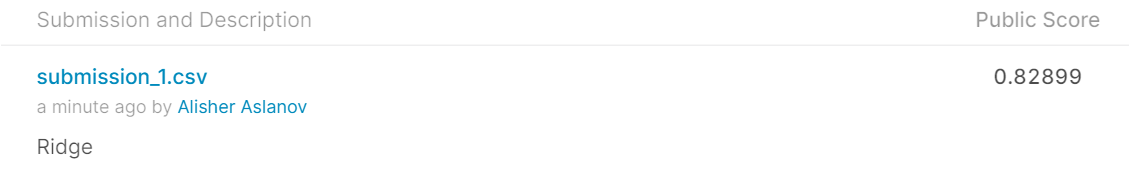

### Часть 2. 2 балла

Обучите логистическую или линейную регрессию на усредненных Word2Vec векторах. 

In [17]:
import numpy as np
from gensim.sklearn_api import W2VTransformer

w2v_tr = W2VTransformer(min_count=1) # !!!
w2v_tr.fit(df_train['negative'])

W2VTransformer(min_count=1)

In [18]:
np.dot(np.array([0.5, 0.5]), w2v_tr.transform(['no', 'car'])).shape # weighting

(100,)

In [19]:
A = [[1, 2, 3, 10, 100],
     [4, 5, 6, 69, 420]]
B = [[8, 52],
     [7, 77]]
np.concatenate((A, B), axis=1)

array([[  1,   2,   3,  10, 100,   8,  52],
       [  4,   5,   6,  69, 420,   7,  77]])

In [20]:
def embed_texts(w2v_tr, texts, size):
    return np.array([w2v_tr.transform(sentence).mean(axis=0) if len(sentence) != 0 else np.zeros(size) \
                     for sentence in texts])

def get_w2v_features(df_train, df_test, embed_func, size=100):
    w2v_neg = W2VTransformer(size=size, min_count=1).fit(pd.concat([df_train['negative'], df_test['negative']])) # it's OK
    w2v_pos = W2VTransformer(size=size, min_count=1).fit(pd.concat([df_train['positive'], df_test['positive']]))
    X_train = np.concatenate((embed_func(w2v_neg, df_train['negative'], size),
                              embed_func(w2v_pos, df_train['positive'], size)), axis=1)
    X_test = np.concatenate((embed_func(w2v_neg, df_test['negative'], size),
                             embed_func(w2v_pos, df_test['positive'], size)), axis=1)
    return X_train, X_test

def simple_w2v(df_train, df_test, emb_size=100):
    X_train, X_test, y_train, y_test = *get_w2v_features(df_train, df_test, embed_texts, emb_size), df_train['score'], df_test['score']
    model = Ridge()
    model.fit(X_train, y_train)
    return mean_absolute_error(y_train, model.predict(X_train)), mean_absolute_error(y_test, model.predict(X_test))

train_error, test_error = simple_w2v(df_train, df_test)
print(f'Train MAE: {train_error}')
print(f'Val MAE: {test_error}')

Train MAE: 0.9597676739396098
Val MAE: 0.9685203910947886


Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

In [21]:
def get_idf_vector(sentence, idf_dict):
    return np.array([idf_dict[token] for token in sentence])

def embed_texts_idf(w2v_tr, texts, size):
    tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False).fit(texts)
    idf_dict = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))
    return np.array([np.dot(get_idf_vector(sentence, idf_dict), w2v_tr.transform(sentence)) if len(sentence) != 0 else np.zeros(size) \
                     for sentence in texts])

def w2v_with_idf(df_train, df_test, emb_size=100):
    X_train, X_test, y_train, y_test = *get_w2v_features(df_train, df_test, embed_texts_idf, emb_size), df_train['score'], df_test['score']
    model = Ridge()
    model.fit(X_train, y_train)
    return mean_absolute_error(y_train, model.predict(X_train)), mean_absolute_error(y_test, model.predict(X_test))

train_error, test_error = w2v_with_idf(df_train, df_test)
print(f'Train MAE: {train_error}')
print(f'Val MAE: {test_error}')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Train MAE: 0.9514482548446263
Val MAE: 0.9693906858799992


Источники:
* https://datascience.stackexchange.com/a/44048

Качество не очень впечатляет :( Сделаем лемматизацию:

In [23]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

def process_lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

df_train['negative'].apply(process_lemmatize)
df_train['positive'].apply(process_lemmatize)
df_test['negative'].apply(process_lemmatize)
df_test['positive'].apply(process_lemmatize)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


81543                                     [location, only]
87964    [the, location, wa, perfect, the, staff, were,...
18772    [very, good, clean, room, close, to, centre, o...
54486    [the, room, were, very, clean, and, the, bathr...
99369           [staff, very, good, breakfast, very, good]
                               ...                        
94061    [food, great, value, with, big, serving, greek...
97855       [1, min, from, the, central, railway, station]
45619                                       [no, positive]
84167                                       [no, positive]
40311                                [nothing, stand, out]
Name: positive, Length: 25000, dtype: object

In [24]:
train_error, test_error = simple_w2v(df_train, df_test, emb_size=500)
print(f'Train MAE: {train_error}')
print(f'Val MAE: {test_error}')

Train MAE: 0.9419496986943472
Val MAE: 0.9511018284482273


Небольшой микро-прирост имеется, но этого всё ещё не достаточно.

Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга. 



In [25]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='darkgrid')

In [ ]:
from tqdm.notebook import tqdm

train_errors = {'simple_w2v': [], 'w2v_with_idf': []}
val_errors = {'simple_w2v': [], 'w2v_with_idf': []}
emb_sizes = [50, 100, 200, 300, 500, 750, 1000]

for emb_size in tqdm(emb_sizes):
    train_error, val_error = simple_w2v(df_train, df_test, emb_size=emb_size)
    train_errors['simple_w2v'].append(train_error)
    val_errors['simple_w2v'].append(val_error)

    train_error, val_error = w2v_with_idf(df_train, df_test, emb_size=emb_size)
    train_errors['w2v_with_idf'].append(train_error)
    val_errors['w2v_with_idf'].append(val_error)

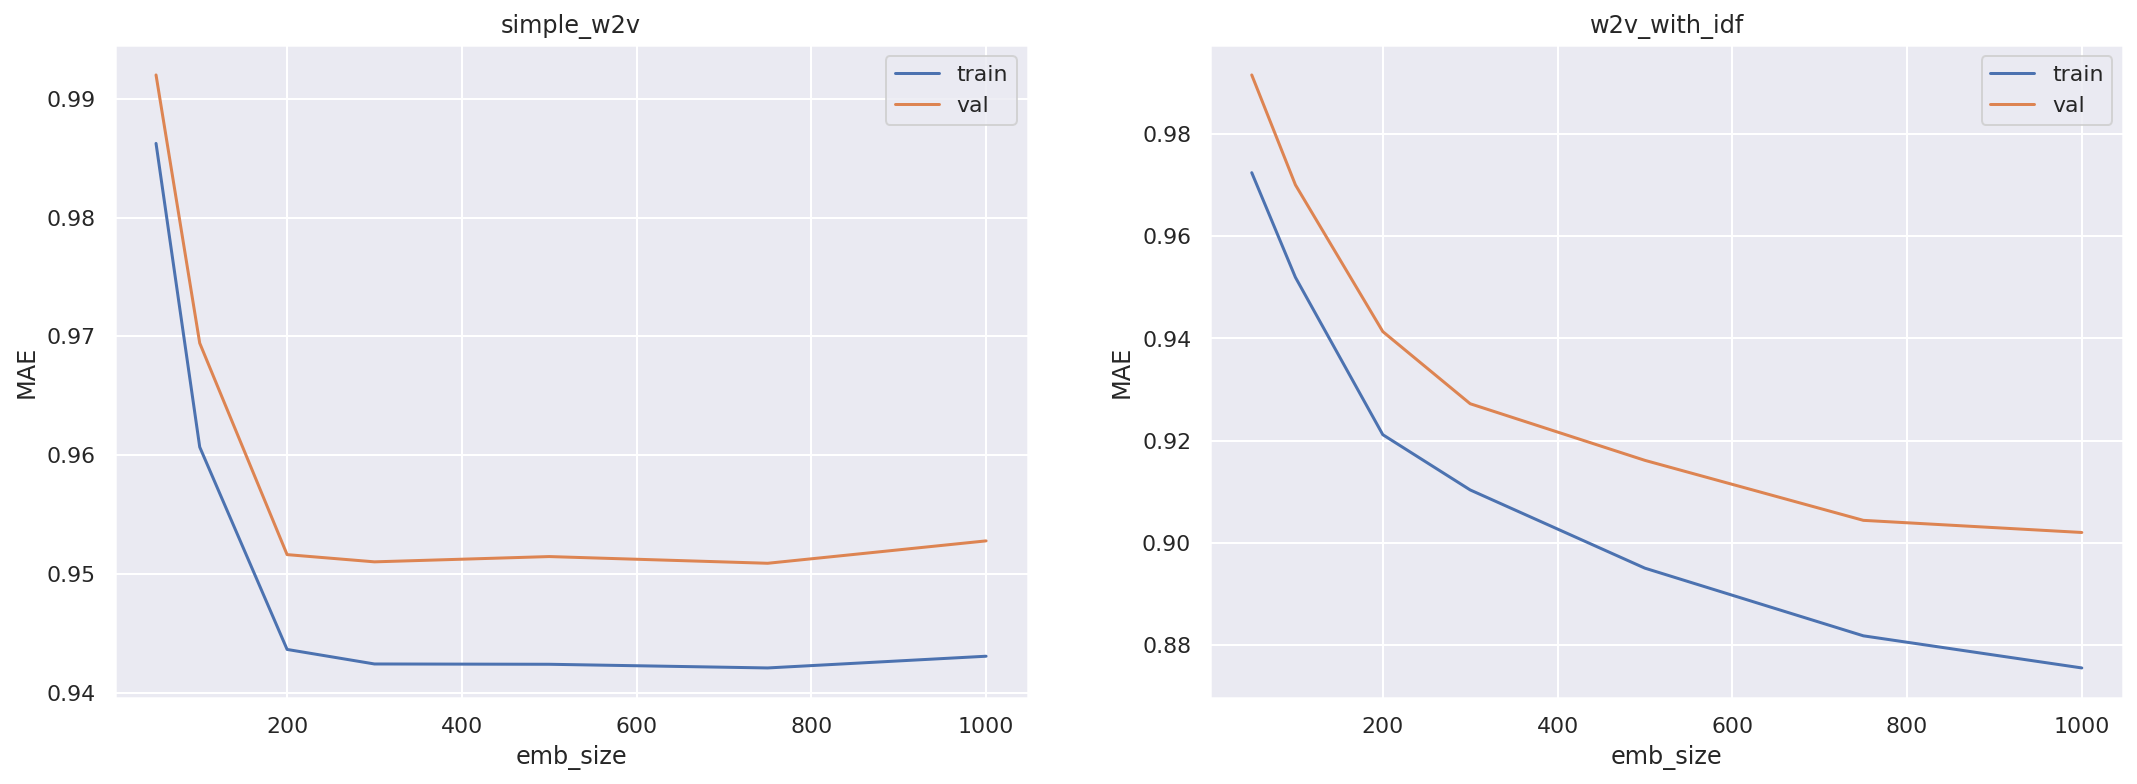

In [27]:
plt.figure(figsize=(18, 6))

plt.subplot2grid((1, 2), (0, 0))
plt.plot(emb_sizes, train_errors['simple_w2v'], label='train')
plt.plot(emb_sizes, val_errors['simple_w2v'], label='val')
plt.xlabel('emb_size')
plt.ylabel('MAE')
plt.title('simple_w2v')
plt.legend()

plt.subplot2grid((1, 2), (0, 1))
plt.plot(emb_sizes, train_errors['w2v_with_idf'], label='train')
plt.plot(emb_sizes, val_errors['w2v_with_idf'], label='val')
plt.xlabel('emb_size')
plt.ylabel('MAE')
plt.title('w2v_with_idf')
plt.legend()

plt.show()

#### Сделайте выводы:

Из графиков видно, что методу с усреднением w2v-векторов более-менее всё равно на размер эмбеддинга, начиная с $200$, &mdash; значения метрик с этого момента остаются примерно одинаковыми и, к сожалению, не очень хорошими.

А вот метод со взвешиванием w2v-векторов idf-ами показал себя куда лучше: с увеличением размерности эмбеддинга ошибка становится всё меньше. Но в конце, правда, убывает уже менее стремительно, чем в начале.

**Вывод:** взвешивание idf-ами + эмбеддинги размерности $\geq 500$ = круто 😎

Теперь попробуйте обучить логистическую или линейную регрессию на любых других эмбеддингах размерности $300$ и сравните качество с Word2Vec.


Попробую использовать Doc2Vec:

In [28]:
from gensim.sklearn_api import D2VTransformer

def embed_texts_d2v(d2v_tr, texts, size):
    return np.array([d2v_tr.transform(sentence)[0] if len(sentence) != 0 else np.zeros(size) \
                     for sentence in texts])

def get_d2v_features(df_train, df_test, size=300):
    d2v_neg = D2VTransformer(size=size, min_count=1).fit(pd.concat([df_train['negative'], df_test['negative']]))
    d2v_pos = D2VTransformer(size=size, min_count=1).fit(pd.concat([df_train['positive'], df_test['positive']]))
    X_train = np.concatenate((embed_texts_d2v(d2v_neg, df_train['negative'], size),
                              embed_texts_d2v(d2v_pos, df_train['positive'], size)), axis=1)
    X_test = np.concatenate((embed_texts_d2v(d2v_neg, df_test['negative'], size),
                             embed_texts_d2v(d2v_pos, df_test['positive'], size)), axis=1)
    return X_train, X_test


X_train, X_test, y_train, y_test = *get_d2v_features(df_train, df_test), df_train['score'], df_test['score']
model = Ridge()
model.fit(X_train, y_train)
print('--- D2V 300 ---')
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(X_train))}')
print(f'Val MAE: {mean_absolute_error(y_test, model.predict(X_test))}')

--- D2V 300 ---
Train MAE: 1.0353184004635427
Val MAE: 1.0507424794945037


In [29]:
print('--- W2V + IDF 300 ---')
print(f'Train MAE: {train_errors["w2v_with_idf"][3]}')
print(f'Val MAE: {val_errors["w2v_with_idf"][3]}')

--- W2V + IDF 300 ---
Train MAE: 0.9103479276142162
Val MAE: 0.927220362601065


#### Выводы:
Очевидно, метод со взвешиванием w2v-векторов в клочья рвёт метод с d2v. Багов нет, я проверил; возможно, размер эмбеддинга маловат, поэтому такое плохое качество.

Предскажите вашей лучшей моделью из этого задания тестовые данные из [соревнования](https://www.kaggle.com/t/3e8fa6cec6d048bf8e93fb72e441d88c) и сделайте сабмит. Какой у вас получился скор? Прикрепите скриншот из кэггла.

Моя лучшая модель в этом задании &mdash; гребневая регрессия, обученная на w2v-векторах размерности $1000$, взвешенных idf-ами, будем использовать её:

In [30]:
test_data['negative'] = test_data['negative'].apply(process_lemmatize)
test_data['positive'] = test_data['positive'].apply(process_lemmatize)

In [ ]:
X_train, X_test, y_train = *get_w2v_features(df, test_data, embed_texts_idf, 1000), df['score']
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

submission_2 = pd.DataFrame({'review_id': test_data['review_id'],
                             'score': y_pred})
submission_2.to_csv('submission_2.csv', index=False)

In [32]:
!kaggle competitions submit -c intro-to-dl-hw03 -f submission_2.csv -m "Ridge w2v_with_idf 1000"

100% 994k/994k [00:00<00:00, 3.17MB/s]
Successfully submitted to Intro to deep learning 2021, homework 3

Посылка в Kaggle:  
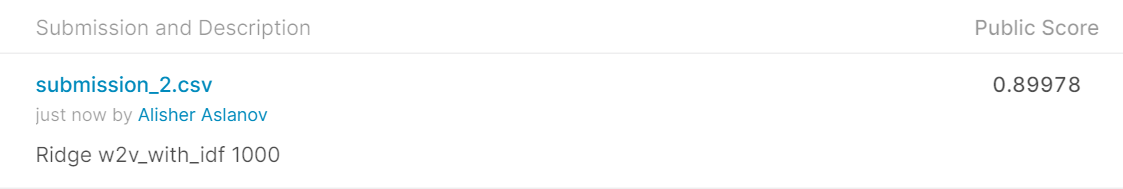

### Часть 3. 4 балла

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см. пример `pad_sequence`)

Источники:
* https://youtu.be/L1i3M8xRdzQ
* https://youtu.be/0u3ioSwev3s

In [ ]:
!pip install transformers datasets

In [8]:
import torch
from torch import nn
from torch.nn import functional as F

import transformers as ts
from datasets import Dataset

In [10]:
MODEL_NAME = 'distilbert-base-uncased'

data = pd.read_csv(PATH_TO_TRAIN_DATA)
data.rename(columns={'score': 'label'}, inplace=True)
train_data, val_data = train_test_split(data, test_size=0.2, random_state=1412)
test_data = pd.read_csv(PATH_TO_TEST_DATA)

train_data = Dataset.from_pandas(train_data).remove_columns(['__index_level_0__'])
val_data = Dataset.from_pandas(val_data).remove_columns(['__index_level_0__'])
test_data = Dataset.from_pandas(test_data) # no 'label' column

train_data, val_data, test_data

(Dataset({
     features: ['review_id', 'negative', 'positive', 'label'],
     num_rows: 80000
 }), Dataset({
     features: ['review_id', 'negative', 'positive', 'label'],
     num_rows: 20000
 }), Dataset({
     features: ['review_id', 'negative', 'positive'],
     num_rows: 20000
 }))

In [ ]:
tokenizer = ts.AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir='tmp')
tokenizer

In [12]:
def tokenize(instance):
    return tokenizer(instance['negative'], instance['positive'], truncation=True)

train_data = train_data.map(tokenize)
val_data = val_data.map(tokenize)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [13]:
train_data = train_data.remove_columns(['review_id', 'negative', 'positive'])
val_data = val_data.remove_columns(['review_id', 'negative', 'positive'])

In [14]:
data_collator = ts.DataCollatorWithPadding(tokenizer)
data_collator

DataCollatorWithPadding(tokenizer=PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

In [ ]:
model = ts.AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1, cache_dir='tmp')
model

In [30]:
if torch.cuda.is_available():
    model.cuda()

In [31]:
training_args = ts.TrainingArguments(
    output_dir='tmp/model_output',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    learning_rate=3e-5,
    weight_decay=1e-2,
    max_grad_norm=1.,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    logging_strategy='epoch',
    save_strategy='epoch',
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [32]:
trainer = ts.Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_data,
    eval_dataset=val_data
)

In [33]:
trainer.place_model_on_device

True

In [34]:
torch.cuda.empty_cache()

In [35]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 80000
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5000


Epoch,Training Loss,Validation Loss
1,2.899400,1.048270


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 128
Saving model checkpoint to tmp/model_output/checkpoint-5000
Configuration saved in tmp/model_output/checkpoint-5000/config.json
Model weights saved in tmp/model_output/checkpoint-5000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from tmp/model_output/checkpoint-5000 (score: 1.0482701063156128).


TrainOutput(global_step=5000, training_loss=2.899432421875, metrics={'train_runtime': 2418.6295, 'train_samples_per_second': 33.077, 'train_steps_per_second': 2.067, 'total_flos': 2844752886802944.0, 'train_loss': 2.899432421875, 'epoch': 1.0})

In [36]:
test_data = test_data.map(tokenize)

0ex [00:00, ?ex/s]

In [37]:
predictions = trainer.predict(test_data)
predictions

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: review_id, positive, negative.
***** Running Prediction *****
  Num examples = 20000
  Batch size = 128


PredictionOutput(predictions=array([[4.0872445],
       [9.705927 ],
       [6.594796 ],
       ...,
       [9.877538 ],
       [7.070941 ],
       [8.264209 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 343.4496, 'test_samples_per_second': 58.233, 'test_steps_per_second': 0.457})

In [51]:
submission_3 = pd.DataFrame({'review_id': test_data['review_id'],
                             'score': predictions.predictions.T[0]})
submission_3.to_csv('submission_3.csv', index=False)

In [52]:
!kaggle competitions submit -c intro-to-dl-hw03 -f submission_3.csv -m "distilbert-base-uncased"

100% 823k/823k [00:03<00:00, 253kB/s]
Successfully submitted to Intro to deep learning 2021, homework 3

### Контест (до 3 баллов)

По итогам всех ваших экспериментов выберите модель, которую считаете лучшей. Сделайте сабмит в контест. В зависимости от вашего скора на публичном лидерборде, мы начислим вам баллы:

 - <0.76 - 3 балла
 - [0.76; 0.78) - 2 балла
 - [0.78; 0.8) - 1 балл

Несмотря на то, что лосс на валидации у моего трансформера оставляет желать лучшего, на тестовых данных он показал себя просто отлично:  
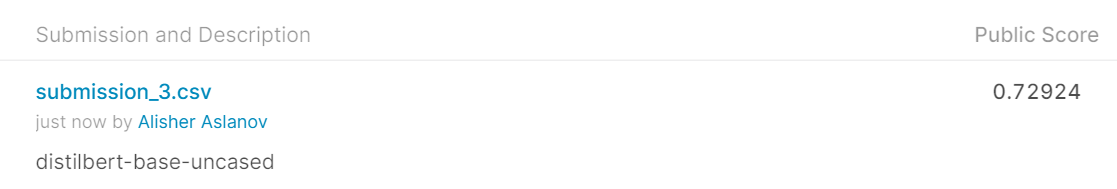